In [1]:
import mdtraj as md
import MDAnalysis as mda
import numpy as np
from scipy.stats import ttest_ind_from_stats

from tqdm import tqdm
from pathlib import Path
import os
from natsort import natsorted
import pandas as pd
from addict import Dict as Adict

import pyemma as pm
import deeptime as dt
import deeptime.markov.msm as msm
import deeptime.markov.hmm as hmm

from deeptime.plots import plot_implied_timescales, plot_energy2d, plot_contour2d_from_xyz, plot_flux
from deeptime.markov.sample import *
from deeptime.markov import TransitionCountEstimator
from deeptime.util import energy2d

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from funcs_build_msm import _tica, _kmeans, get_data 
from funcs_validate_msm import *
from funcs_sample import *
from funcs_plotting import *
from funcs_characterise import *
from paths import *

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
study_name = 'n_clusters'
data_path = Path(f'data_egfr/msm/{study_name}')
summary_f = data_path/f'{study_name}.h5'
hps = pd.read_hdf(summary_f, key='hps')
raw = pd.read_hdf(summary_f, key='result_raw')

summary = raw.groupby('hp_id')[['t2', 'gap_2', 't3', 'gap_3']].agg(['mean', 'std'])
summary

t2                   gap_2                        t3  \
               mean           std      mean        std           mean   
hp_id                                                                   
0      4.258766e+06  4.993950e+06  9.877259  10.570731  438539.507225   
1      2.927477e+06  3.859451e+06  7.083355   7.666884  420395.265777   
2      3.770089e+06  5.647987e+06  8.087046  10.971600  476668.578812   
3      3.775350e+06  5.297374e+06  7.257305   8.182101  513894.618174   

                         gap_3            
                 std      mean       std  
hp_id                                     
0      340220.880011  2.368782  1.164973  
1      355997.202171  2.458528  1.548529  
2      398473.507520  2.461085  1.242254  
3      397912.479254  2.509716  1.214368

In [3]:
hp_id = 0
hp_dict = Adict(hps[hps.hp_id == hp_id].to_dict('records')[0])
features = ['dbdist', 'dbdihed', 'aloop', 'ploopdihed', 'achelix']

savedir = Path(f'data_egfr/msm/validation/{study_name}_hp{hp_id}_validate')
savedir.mkdir(exist_ok=True, parents=True)

hp_dict

{'hp_id': 0,
 'trajlen__cutoff': 1000,
 'n__boot': 20,
 'seed': 49587,
 'tica__lag': 10,
 'tica__stride': 1000,
 'tica__dim': 20,
 'cluster__k': 1000,
 'cluster__stride': 1000,
 'cluster__maxiter': 1000,
 'markov__lag': 100}

In [5]:
ftrajs, traj_mapping = get_data(trajlen_cutoff=hp_dict.trajlen__cutoff, features=features, ftraj_dir=ftraj_dir)

Loading feature:  dbdist


100%|██████████| 3472/3472 [00:18<00:00, 190.63it/s]  


Loading feature:  dbdihed


100%|██████████| 3472/3472 [00:39<00:00, 87.19it/s] 


Loading feature:  aloop


100%|██████████| 3472/3472 [03:22<00:00, 17.19it/s]


Loading feature:  ploopdihed


100%|██████████| 3472/3472 [01:01<00:00, 56.05it/s]


Loading feature:  achelix


100%|██████████| 3472/3472 [00:34<00:00, 101.37it/s]

Loaded number of ftrajs: 1988


### Estimate a new model given hyperparameters

In [ ]:
ttrajs, tica_mod = _tica(hp_dict, ftrajs)
ttraj_cat = np.concatenate(ttrajs, axis=0)[:, :3]

tica_mod.save(savedir/'tica_mod')
np.save(savedir/'tica_mean.npy', tica_mod.mean)
np.save(savedir/'tica_cov.npy', tica_mod.cov)
np.save(savedir/'tica_cov_tau.npy', tica_mod.cov_tau)

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 1988/1988 [00:26<00:00, 75.45it/s]                        


In [ ]:
dtrajs, kmeans_mod = _kmeans(hp_dict, ttrajs, seed=hp_dict.seed)
dtraj_cat = np.concatenate(dtrajs, axis=0)
np.save(savedir/f'kmeans_centers.npy', kmeans_mod.clustercenters)

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 1000/1000 [00:02<00:00, 411.82it/s]
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
100%|██████████| 1988/1988 [00:25<00:00, 77.35it/s]                                    


In [ ]:
msm_mod = msm.MaximumLikelihoodMSM(reversible=True, lagtime=hp_dict.markov__lag).fit_fetch(dtrajs)
traj_weights = msm_mod.compute_trajectory_weights(dtrajs)
np.save(savedir/f'msm_tmat.npy', msm_mod.transition_matrix)

In [ ]:
count_mod = TransitionCountEstimator(lagtime=hp_dict.markov__lag, count_mode='sliding').fit_fetch(dtrajs)
msm_mod = msm.MaximumLikelihoodMSM(reversible=True).fit_fetch(count_mod)
traj_weights = msm_mod.compute_trajectory_weights(dtrajs)
np.save(savedir/f'msm_tmat.npy', msm_mod.transition_matrix)

### Load previous model if exists

In [6]:
tica_mod = pm.coordinates.tica()
tica_mod = tica_mod.load(savedir/'tica_mod')
tica_mod

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


TICA(commute_map=False, dim=20, epsilon=1e-06, kinetic_map=True, lag=10,
   ncov_max=inf, reversible=True, skip=0, stride=1000, var_cutoff=0.95,
   weights=None)

In [7]:
ttrajs = tica_mod.transform(ftrajs)
ttraj_cat = np.concatenate(ttrajs, axis=0)[:, :3]

In [8]:
kmeans_centres = np.load(savedir/f'kmeans_centers.npy', allow_pickle=True)
print(kmeans_centres.shape)
tmat = np.load(savedir/f'msm_tmat.npy', allow_pickle=True)
tmat.shape

(1000, 20)


(1000, 1000)

In [9]:
kmeans_mod = pm.coordinates.cluster_kmeans(fixed_seed=hp_dict.seed)
kmeans_mod.set_model_params(kmeans_centres)
dtrajs = kmeans_mod.transform(ttrajs)
dtrajs = [dtraj.flatten() for dtraj in dtrajs]
dtraj_cat = np.concatenate(dtrajs, axis=0)
index_states = compute_index_states(dtrajs)
np.savez(savedir/'index_states.npz', *index_states)

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


In [10]:
stat_dist = dt.markov.tools.analysis.stationary_distribution(tmat)
tcmat = TransitionCountEstimator(lagtime=hp_dict.markov__lag, count_mode='sliding', n_states=hp_dict.cluster__k).fit_fetch(dtrajs)
msm_mod = msm.MarkovStateModel(transition_matrix=tmat, stationary_distribution=stat_dist, lagtime=hp_dict.markov__lag, count_model=tcmat)
traj_weights = msm_mod.compute_trajectory_weights(dtrajs)

### FES and microstate centers

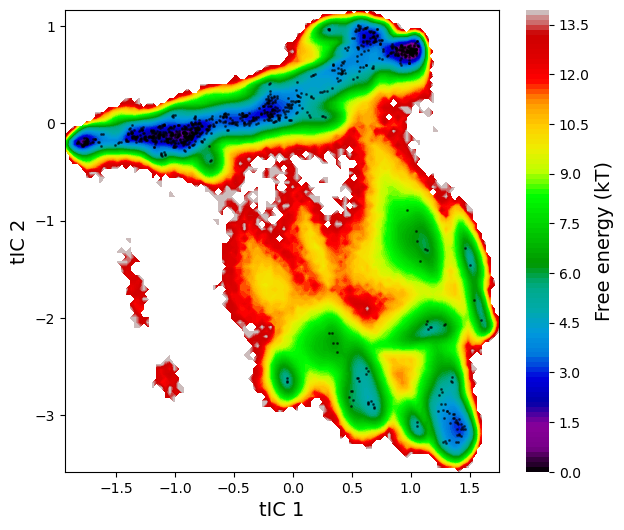

In [ ]:
plot_fe(traj_all=ttraj_cat,
        traj_weights = np.concatenate(traj_weights, axis=0),
        c_centers=kmeans_mod.clustercenters,
        c_centers_s=5,
        savedir=savedir/'free_energy.png')

### Timescales

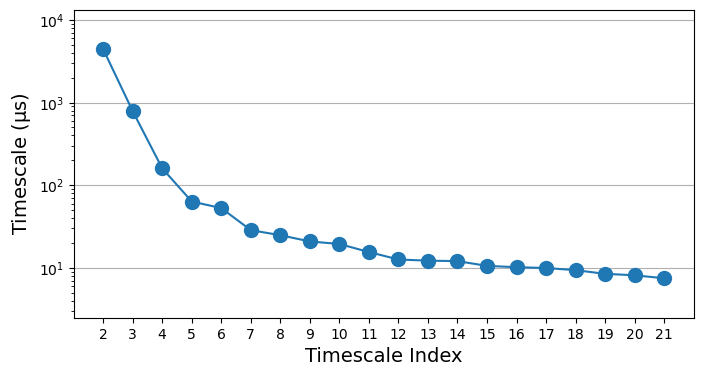

In [ ]:
plot_ts(timescales=msm_mod.timescales(), 
        n_ts = 20, 
        markov_lag = hp_dict.markov__lag, 
        scaling = 0.001, 
        savedir = savedir/'timescales.png', 
        unit="$\mathrm{\mu s}$")

### Coarse-grain with PCCA

In [11]:
n_states = 6
pcca_mod = msm_mod.pcca(n_states)
np.save(savedir/'pcca_memberships.npy', pcca_mod.memberships)
pcca_mod.coarse_grained_stationary_probability

array([0.00285458, 0.00244095, 0.01349342, 0.07511621, 0.23079885,
       0.67529599])

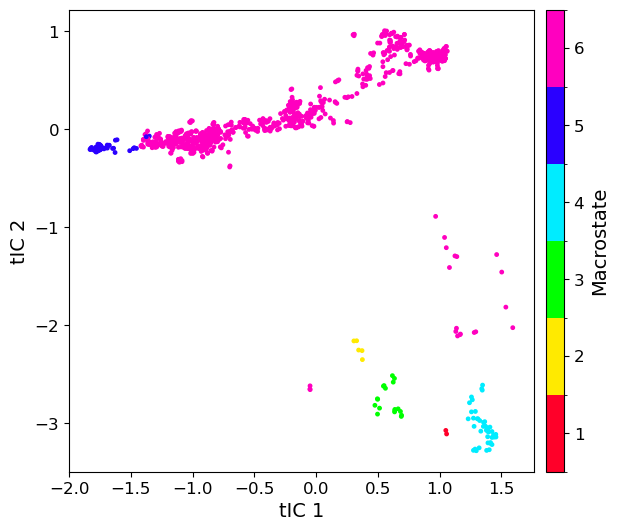

In [ ]:
plot_pcca(state_assignment = pcca_mod.assignments, 
          c_centers = kmeans_mod.clustercenters, 
          savedir = savedir/'pcca.png')

### Project starting conformations onto tICA space

In [ ]:
crystal_files = Path("./human_egfr/").rglob("kinoml*.pdb")
crystal_files = natsorted([str(f) for f in crystal_files])

frames = [] 
for crystal in crystal_files:
    sample_frame = md.load(crystal)
    sample_frame = sample_frame.atom_slice(sample_frame.top.select('mass>1.1'))
    frames.append(sample_frame)
crystals = md.join(frames)
crystals = crystals.superpose(crystals, 0)

In [ ]:
from funcs_featurise import *

featurisers = [dbdist_featuriser, dbdihed_featuriser, aloop_featuriser, ploopdihed_featuriser, achelix_featuriser]

c_ftrajs = []
for f in featurisers:
    ftraj = f(crystals, save_to_disk=None)
    if 'dihed' in f.__name__:
        ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)    
    c_ftrajs.append(ftraj)
c_ftraj_cat = np.concatenate(c_ftrajs, axis=1)
print(c_ftraj_cat.shape)

c_ttraj = tica_mod.transform(c_ftraj_cat)
print(c_ttraj.shape)

(400, 284)
(400, 20)


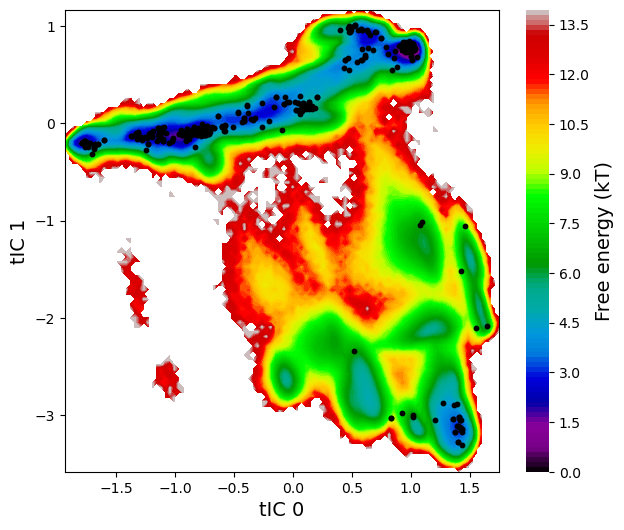

In [ ]:
plot_fe(traj_all=ttraj_cat,
        traj_weights = np.concatenate(traj_weights, axis=0),
        c_centers = c_ttraj,
        c_centers_marker = 'o',
        c_centers_a = 1,
        c_centers_s = 10,
        savedir=savedir/'free_energy_with_initial_states.png')

In [ ]:
c_dtraj = kmeans_mod.transform(c_ttraj).flatten()
unique, counts = np.unique(pcca_mod.assignments[c_dtraj]+1, return_counts=True)
unique, counts

(array([3, 4, 5, 6]), array([  6,  25,  26, 343]))

### Coarse-grained transition matrix and MFPT matrix

In [ ]:
mfpt = np.zeros([n_states, n_states])

for i in range(n_states):
    for j in range(n_states):
        mfpt[i,j] = msm_mod.mfpt(A=pcca_mod.sets[i], B=pcca_mod.sets[j])

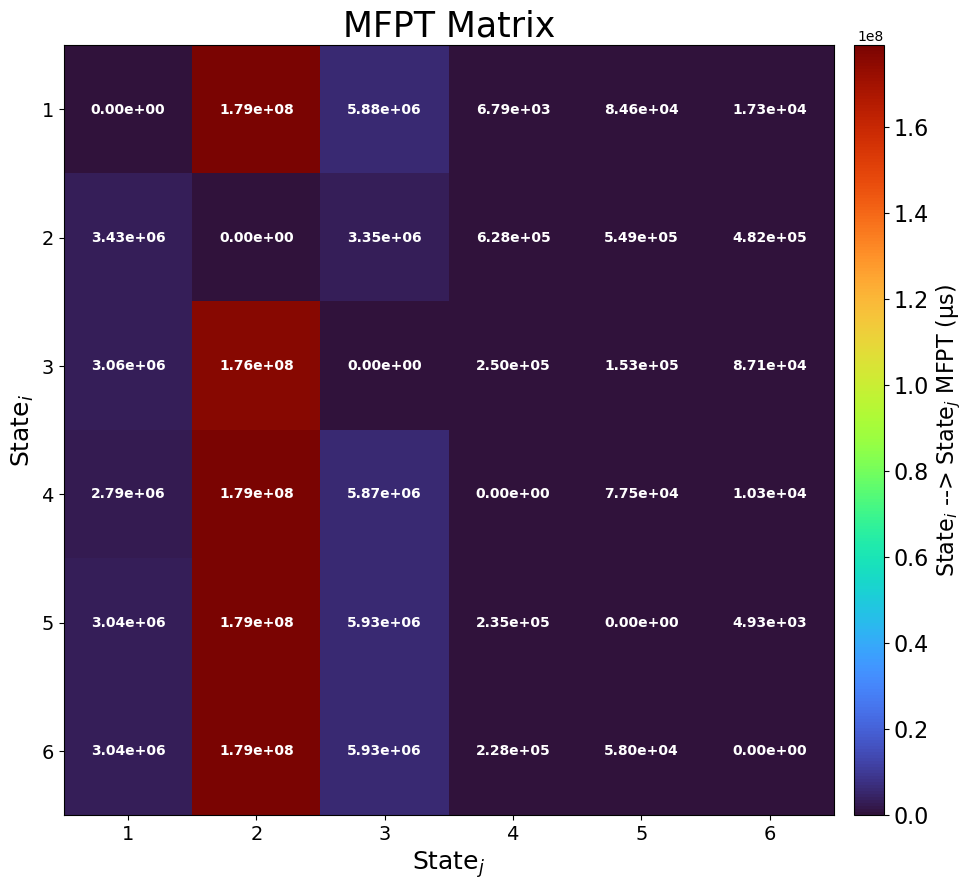

In [ ]:
plot_mfpt_matrix(mfpt = mfpt, 
                 savedir = savedir/'mfpt_matrix.png',
                 scaling=0.1, 
                 unit="$\mathrm{\mu s}$", 
                 text_f =".2e")

### Eigenvectors

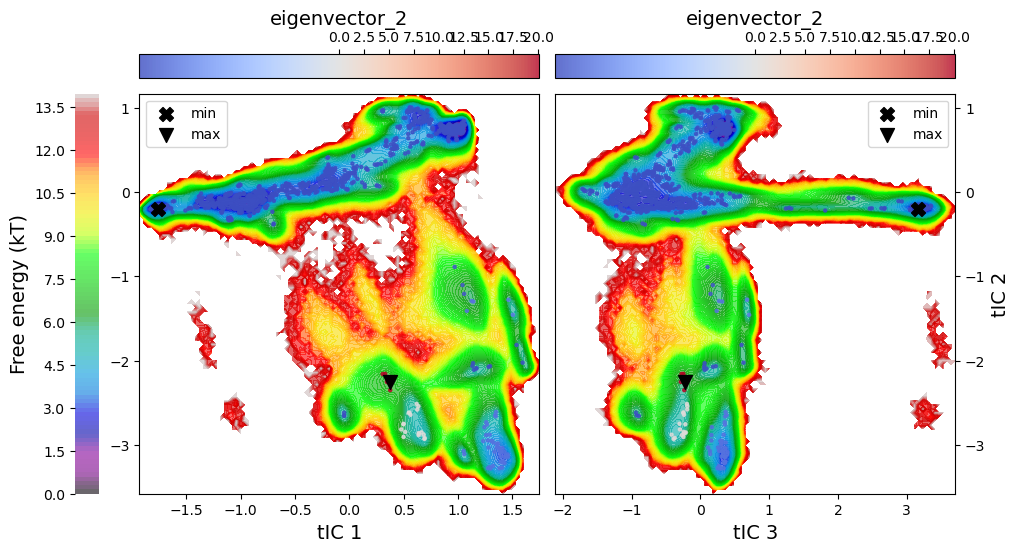

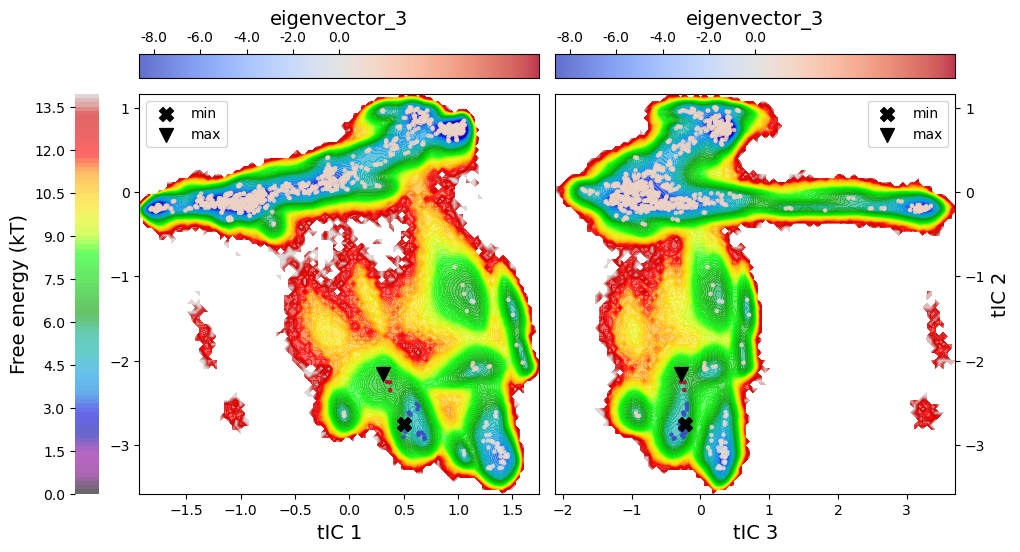

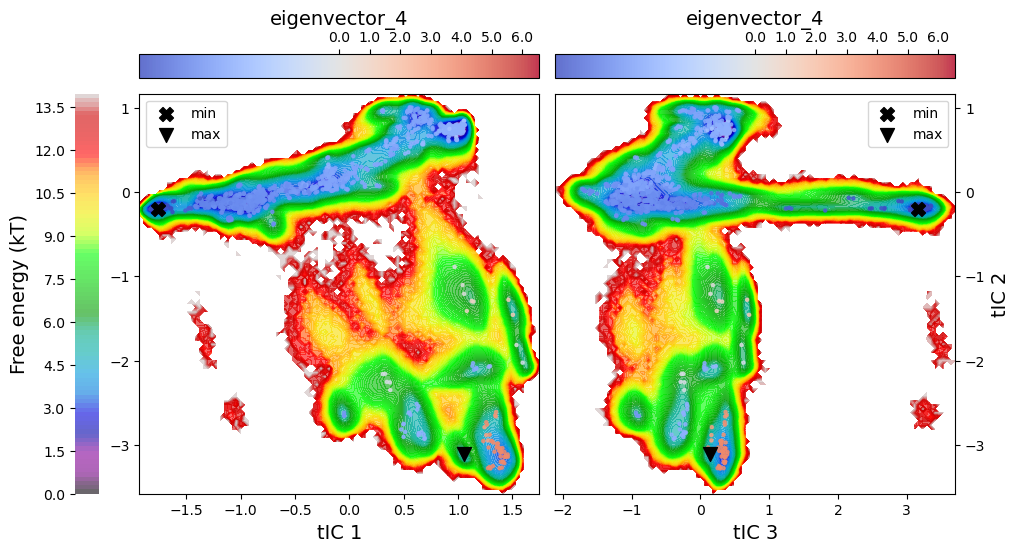

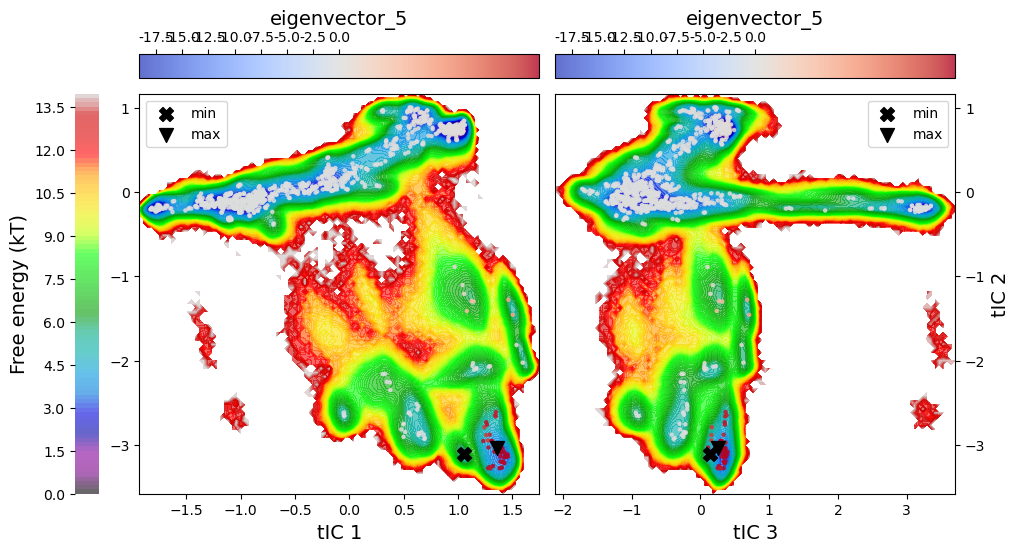

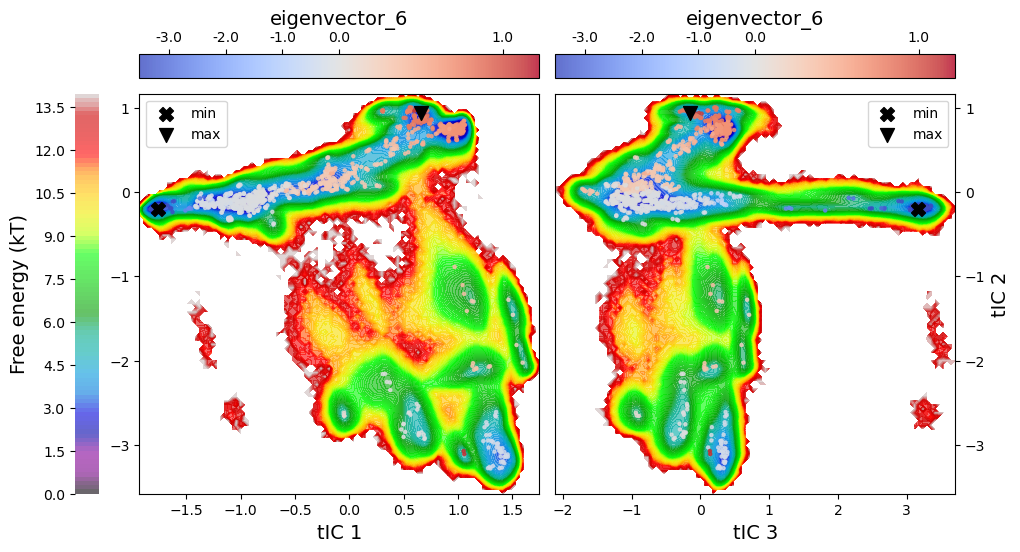

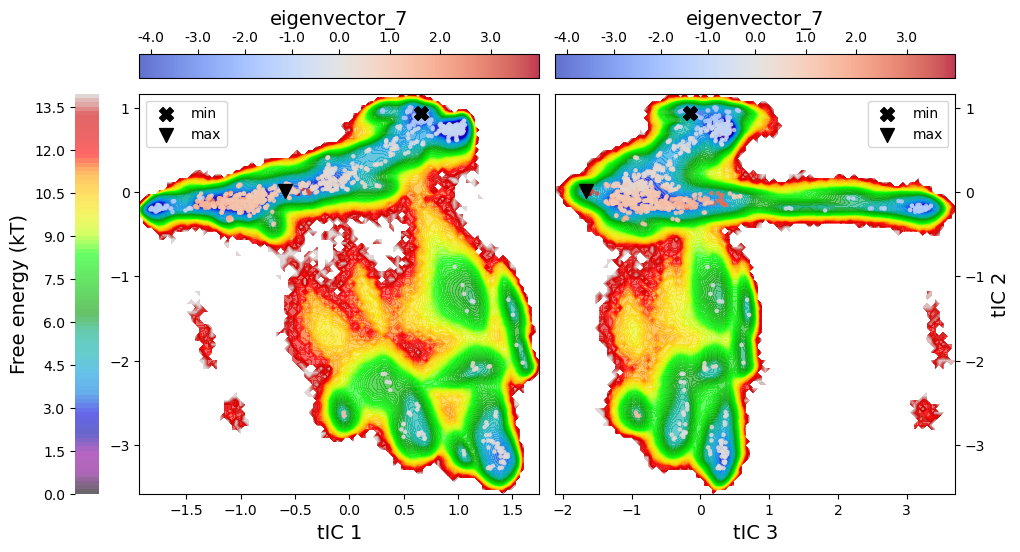

In [ ]:
for ev_id in range(6):
        plot_ev(ev = msm_mod.eigenvectors_right()[:,ev_id+1],
                c_centers = kmeans_mod.cluster_centers_,
                traj_all = ttraj_cat,
                traj_weights = np.concatenate(traj_weights,axis=0),
                title = f'eigenvector_{ev_id+2}',
                savedir = savedir/f'eigenvector_{ev_id+2}.png')

### Sample pcca states and save examples

In [ ]:
for state_i in range(n_states):
    membership_cutoff = 0.9  # Only sample microstates that are highly committed to a macrostate

    memberships = pcca_mod.memberships[:,state_i]
    states_to_sample = memberships > membership_cutoff

    stationary_distribution = msm_mod.stationary_distribution.copy()
    stationary_distribution[~states_to_sample] = 0
    sample_distribution = stationary_distribution / np.sum(stationary_distribution)

    state_samples_count = sample_states_by_distribution(sample_distribution, 20)
    print(state_samples_count) # Print what microstates are sampled and how many samples from each 
    samples = sample_frames_by_states(state_samples_count, dtrajs, mapping=traj_mapping)
    save_samples(samples, traj_files, savedir/f'MS_{state_i+1}.pdb')

{43: 17, 936: 3}
{36: 4, 434: 4, 532: 4, 627: 5, 678: 3}
{11: 2, 60: 2, 125: 2, 374: 1, 383: 1, 493: 1, 589: 2, 614: 2, 657: 2, 828: 2, 868: 2, 966: 1}
{2: 1, 222: 3, 250: 1, 280: 2, 289: 2, 306: 1, 527: 1, 528: 1, 543: 1, 620: 2, 817: 1, 830: 1, 944: 1, 984: 2}
{4: 1, 177: 1, 225: 1, 305: 2, 462: 1, 520: 1, 521: 1, 533: 1, 581: 1, 603: 1, 611: 1, 740: 2, 800: 1, 928: 1, 934: 1, 940: 1, 942: 2}
{23: 3, 46: 1, 120: 4, 427: 1, 455: 1, 504: 1, 570: 2, 579: 2, 726: 2, 874: 3}


### Sample pcca extreme states

In [ ]:
for state_i in range(n_states):
    memberships = pcca_mod.memberships[:,state_i]
    state_samples_count = {np.argmax(memberships) : 20}
    print(state_samples_count) 
    samples = sample_frames_by_states(state_samples_count, dtrajs, mapping=traj_mapping)
    save_samples(samples, traj_files, savedir/f'MS_{state_i+1}_ex.pdb')

{43: 20}
{678: 20}
{11: 20}
{487: 20}
{942: 20}
{726: 20}


### Sample eigenvector extreme states

In [ ]:
for ev_id in range(6):
    ev = msm_mod.eigenvectors_right()[:,ev_id+1]

    ev_min_sample_count = {np.argmin(ev) : 20}
    ev_max_sample_count = {np.argmax(ev) : 20}
    print(ev_min_sample_count, ev_max_sample_count) 

    samples_min = sample_frames_by_states(ev_min_sample_count, dtrajs, mapping=traj_mapping)
    save_samples(samples_min, traj_files, savedir/f'ev_{ev_id+1}_min.pdb')
    samples_max = sample_frames_by_states(ev_max_sample_count, dtrajs, mapping=traj_mapping)
    save_samples(samples_max, traj_files, savedir/f'ev_{ev_id+1}_max.pdb')

{942: 20} {678: 20}
{11: 20} {36: 20}
{942: 20} {43: 20}
{43: 20} {487: 20}
{942: 20} {726: 20}
{726: 20} {14: 20}


### Transitions from state 1 extreme to 5 

In [12]:
state_1_ex_id = msm_mod.eigenvectors_right()[:,1].argmax()
state_1_ids = np.where(pcca_mod.memberships[:,0] > 0.9)[0]
state_5_ids = np.where(pcca_mod.memberships[:,4] > 0.9)[0]

In [68]:
state_1_ids = np.where(pcca_mod.assignments == 0)[0]
state_5_ids = np.where(pcca_mod.assignments == 4)[0]

In [17]:
simulate_traj = msm_mod.simulate(n_steps=100000, start=state_1_ex_id, seed=hp_dict.seed, stop=state_5_ids)
samples = simulated_traj_to_samples(simulate_traj, dtrajs, mapping=traj_mapping)
np.save(savedir/'1_to_5_simulation.npy', samples)

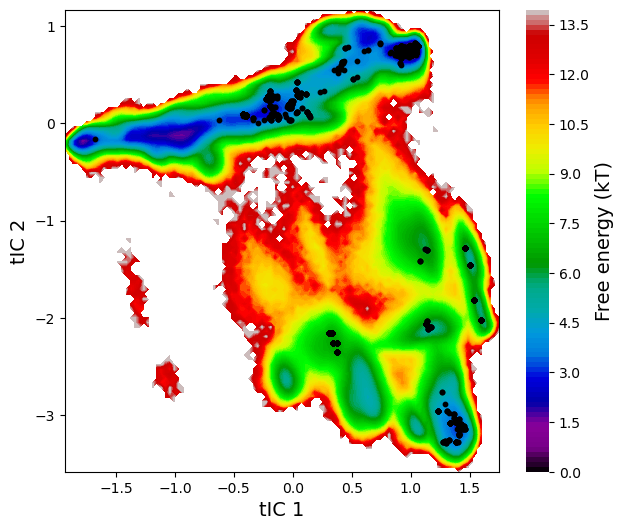

In [ ]:
plot_fe(traj_all=ttraj_cat,
        traj_weights = np.concatenate(traj_weights, axis=0),
        c_centers = kmeans_mod.clustercenters[simulate_traj],
        c_centers_marker = 'o',
        c_centers_a = 1,
        c_centers_s = 10,
        savedir=savedir/'transition_1_to_5_simulated.png')

In [69]:
reactive_flux_15 = msm_mod.reactive_flux(state_1_ids, state_5_ids)
major_flux = reactive_flux_15.major_flux()
paths, capacities = reactive_flux_15.pathways()

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/deeptime/markov/tools/flux/pathways.py:294: RuntimeWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", RuntimeWarning)


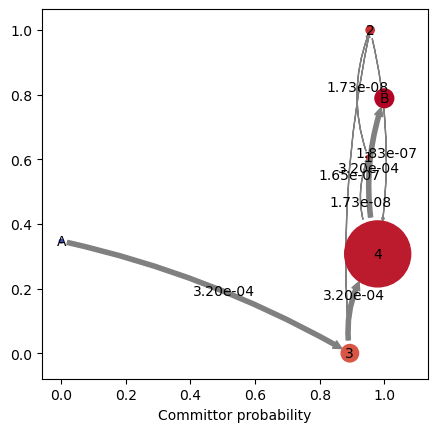

In [75]:
sets, cg_flux = reactive_flux_15.coarse_grain(pcca_mod.sets)
ax, pos = plot_flux(cg_flux, flux_scale=100)
ax.set_aspect('equal')

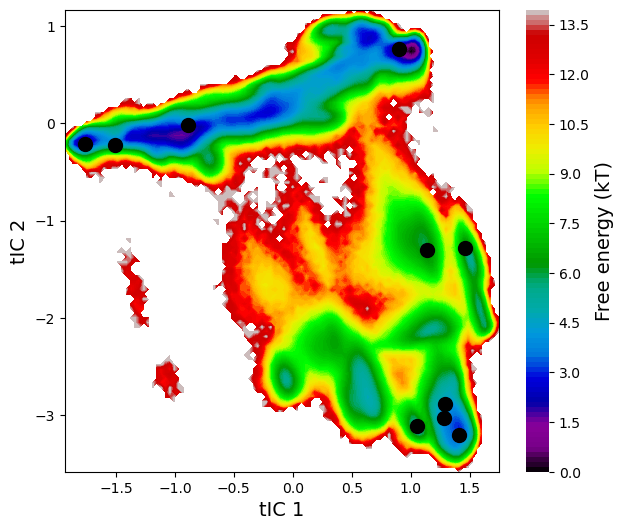

In [ ]:
plot_fe(traj_all=ttraj_cat,
        traj_weights = np.concatenate(traj_weights, axis=0),
        c_centers = kmeans_mod.clustercenters[paths[1]],
        c_centers_marker = 'o',
        c_centers_a = 1,
        c_centers_s = 100,
        savedir=None)

### Transitions from state 5 to state 6 extreme

In [18]:
state_6_ex_id = msm_mod.eigenvectors_right()[:,5].argmax()
state_6_ids = np.where(pcca_mod.memberships[:,5] > 0.9)[0]
state_5_ids = np.where(pcca_mod.memberships[:,4] > 0.9)[0]

In [64]:
state_6_ids = np.where(pcca_mod.assignments == 5)[0]
state_5_ids = np.where(pcca_mod.assignments == 4)[0]

In [19]:
simulate_traj = msm_mod.simulate(n_steps=100000, start=state_6_ex_id, stop=state_5_ids, seed=hp_dict.seed)
samples = simulated_traj_to_samples(simulate_traj, dtrajs, mapping=traj_mapping)
np.save(savedir/'6_to_5_simulation.npy', samples)

In [65]:
reactive_flux_56 = msm_mod.reactive_flux(state_6_ids, state_5_ids)
major_flux = reactive_flux_56.major_flux()
paths, capacities = reactive_flux_56.pathways()

### Plot reactive flux network 

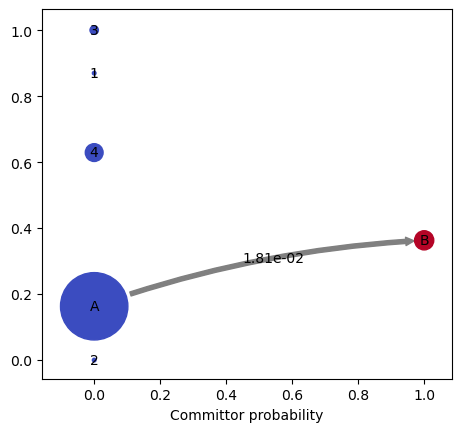

In [67]:
sets, cg_flux = reactive_flux_56.coarse_grain(pcca_mod.sets)
ax, pos = plot_flux(cg_flux, flux_scale=100)
ax.set_aspect('equal')